In [2]:
import pandas as pd
import seaborn as sns
from IPython.display import display
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)


quantificators = ["CC", "ACC", "PCC", "PACC", "DyS", "EMQ","MLPE"]
error = "MAE"
ps_train = [0.25, 0.5, 0.75]
ps_test = [0.25, 0.5, 0.75]
dateexperiment = "2022_07_12_16_20"


results_dict={}
#order = ("2_2","3_3","4_4","3_2","2_3","4_3","3_4","4_2","2_4")
print("Loading results... ",sep="")
for quant_name in quantificators:
    results_dict[quant_name] = pd.read_csv("results/concept/results_%s_%s.csv" % (dateexperiment,quant_name),index_col=0)
    results_dict[quant_name]['MAE'] = results_dict[quant_name]['error'].abs()
    results_dict[quant_name]['cut_points'] = results_dict[quant_name]['cut_point_train']-results_dict[quant_name]['cut_point_test']
print("Done")


mean_error_methods = {}

writer = pd.ExcelWriter('results/concept/excel/errors_%s.xlsx' % dateexperiment, engine='xlsxwriter')
for p_train in ps_train:
    for p_test in ps_test:
        for quant_name in quantificators:
            exp_id = "%s_%f_%f" % (quant_name,p_train,p_test)
            results = results_dict[quant_name]
            results = results.loc[(results['p_test'] == p_test) & (results['p_train'] == p_train)]
            results_mean = results.groupby(['cut_point_train', 'cut_point_test'])['MAE'].mean().reset_index()
            #convert to matrix form
            results_mean = results_mean.pivot(index='cut_point_train', columns='cut_point_test', values='MAE')
            mean_error_methods[exp_id]=results_mean.mean().mean()
            print("Results for method %s. p_train: %f. p_test: %f. Mean %s: %f" % (quant_name,p_train, p_test,error,mean_error_methods[exp_id]))
            cm = sns.light_palette('red', as_cmap=True)
            display(results_mean.style.background_gradient(cmap=cm,low=0,high=1))
            results_mean.to_excel(writer, sheet_name=exp_id)
            workbook = writer.book
            worksheet = writer.sheets[exp_id]
            # Apply a conditional format to the cell range.
            worksheet.conditional_format('B2:D4', {'type': '2_color_scale','min_type':'num','max_type':'num','min_value':'0','max_value':'1','min_color':'#f3f0f0','max_color':'#ff0000'})
writer.close()

Loading results... 
Done
Results for method CC. p_train: 0.250000. p_test: 0.250000. Mean MAE: 0.050444


cut_point_test,2,3,4
cut_point_train,,,
2,0.010667,0.053667,0.165667
3,0.042667,0.011333,0.070000
4,0.052000,0.024667,0.023333


Results for method ACC. p_train: 0.250000. p_test: 0.250000. Mean MAE: 0.080660


cut_point_test,2,3,4
cut_point_train,,,
2,0.023851,0.097371,0.261811
3,0.046777,0.019977,0.132761
4,0.082778,0.029442,0.031170


Results for method PCC. p_train: 0.250000. p_test: 0.250000. Mean MAE: 0.043992


cut_point_test,2,3,4
cut_point_train,,,
2,0.009055,0.041999,0.141173
3,0.037104,0.008372,0.061828
4,0.051984,0.030172,0.014240


Results for method PACC. p_train: 0.250000. p_test: 0.250000. Mean MAE: 0.084556


cut_point_test,2,3,4
cut_point_train,,,
2,0.012649,0.097150,0.258131
3,0.061030,0.013215,0.132327
4,0.102056,0.056523,0.027926


Results for method DyS. p_train: 0.250000. p_test: 0.250000. Mean MAE: 0.079114


cut_point_test,2,3,4
cut_point_train,,,
2,0.017890,0.098347,0.245458
3,0.055375,0.012976,0.119878
4,0.092000,0.051807,0.018296


Results for method EMQ. p_train: 0.250000. p_test: 0.250000. Mean MAE: 0.083445


cut_point_test,2,3,4
cut_point_train,,,
2,0.010984,0.100468,0.277176
3,0.057719,0.008792,0.129648
4,0.089002,0.049565,0.027646


Results for method MLPE. p_train: 0.250000. p_test: 0.250000. Mean MAE: 0.000000


cut_point_test,2,3,4
cut_point_train,,,
2,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000


Results for method CC. p_train: 0.250000. p_test: 0.500000. Mean MAE: 0.084556


cut_point_test,2,3,4
cut_point_train,,,
2,0.073667,0.036333,0.063667
3,0.134000,0.092000,0.016667
4,0.164333,0.116333,0.064000


Results for method ACC. p_train: 0.250000. p_test: 0.500000. Mean MAE: 0.080988


cut_point_test,2,3,4
cut_point_train,,,
2,0.022774,0.080015,0.225261
3,0.056629,0.010060,0.131885
4,0.116188,0.044392,0.041689


Results for method PCC. p_train: 0.250000. p_test: 0.500000. Mean MAE: 0.096751


cut_point_test,2,3,4
cut_point_train,,,
2,0.096955,0.058630,0.027548
3,0.138757,0.104431,0.031465
4,0.180524,0.144169,0.088276


Results for method PACC. p_train: 0.250000. p_test: 0.500000. Mean MAE: 0.086625


cut_point_test,2,3,4
cut_point_train,,,
2,0.019735,0.089601,0.225940
3,0.049916,0.024267,0.143334
4,0.121234,0.055759,0.049837


Results for method DyS. p_train: 0.250000. p_test: 0.500000. Mean MAE: 0.083882


cut_point_test,2,3,4
cut_point_train,,,
2,0.020841,0.085470,0.212605
3,0.068548,0.030250,0.118628
4,0.126983,0.070501,0.021114


Results for method EMQ. p_train: 0.250000. p_test: 0.500000. Mean MAE: 0.087138


cut_point_test,2,3,4
cut_point_train,,,
2,0.016482,0.099771,0.227151
3,0.064587,0.015078,0.132444
4,0.123149,0.063858,0.041723


Results for method MLPE. p_train: 0.250000. p_test: 0.500000. Mean MAE: 0.250000


cut_point_test,2,3,4
cut_point_train,,,
2,0.250000,0.250000,0.250000
3,0.250000,0.250000,0.250000
4,0.250000,0.250000,0.250000


Results for method CC. p_train: 0.250000. p_test: 0.750000. Mean MAE: 0.166074


cut_point_test,2,3,4
cut_point_train,,,
2,0.151667,0.117000,0.066667
3,0.226667,0.175000,0.109667
4,0.274333,0.214000,0.159667


Results for method ACC. p_train: 0.250000. p_test: 0.750000. Mean MAE: 0.073589


cut_point_test,2,3,4
cut_point_train,,,
2,0.028294,0.067885,0.149392
3,0.070471,0.013749,0.099224
4,0.145780,0.052864,0.034640


Results for method PCC. p_train: 0.250000. p_test: 0.750000. Mean MAE: 0.202222


cut_point_test,2,3,4
cut_point_train,,,
2,0.193330,0.154185,0.111655
3,0.245141,0.200677,0.141765
4,0.308515,0.260241,0.204485


Results for method PACC. p_train: 0.250000. p_test: 0.750000. Mean MAE: 0.079503


cut_point_test,2,3,4
cut_point_train,,,
2,0.023969,0.089316,0.156357
3,0.048660,0.027596,0.123772
4,0.144324,0.055733,0.045804


Results for method DyS. p_train: 0.250000. p_test: 0.750000. Mean MAE: 0.076024


cut_point_test,2,3,4
cut_point_train,,,
2,0.028701,0.075117,0.127189
3,0.080190,0.029196,0.082349
4,0.158150,0.091855,0.011471


Results for method EMQ. p_train: 0.250000. p_test: 0.750000. Mean MAE: 0.069538


cut_point_test,2,3,4
cut_point_train,,,
2,0.013969,0.078515,0.127908
3,0.068179,0.011533,0.083937
4,0.150558,0.068067,0.023173


Results for method MLPE. p_train: 0.250000. p_test: 0.750000. Mean MAE: 0.500000


cut_point_test,2,3,4
cut_point_train,,,
2,0.500000,0.500000,0.500000
3,0.500000,0.500000,0.500000
4,0.500000,0.500000,0.500000


Results for method CC. p_train: 0.500000. p_test: 0.250000. Mean MAE: 0.094926


cut_point_test,2,3,4
cut_point_train,,,
2,0.063333,0.138667,0.263667
3,0.022667,0.067667,0.159667
4,0.008000,0.039667,0.091000


Results for method ACC. p_train: 0.500000. p_test: 0.250000. Mean MAE: 0.088008


cut_point_test,2,3,4
cut_point_train,,,
2,0.012701,0.093882,0.268773
3,0.051152,0.013815,0.141706
4,0.117428,0.073623,0.018990


Results for method PCC. p_train: 0.500000. p_test: 0.250000. Mean MAE: 0.121145


cut_point_test,2,3,4
cut_point_train,,,
2,0.099218,0.158406,0.257988
3,0.064063,0.102306,0.182313
4,0.040154,0.072094,0.113767


Results for method PACC. p_train: 0.500000. p_test: 0.250000. Mean MAE: 0.088842


cut_point_test,2,3,4
cut_point_train,,,
2,0.013171,0.093115,0.261982
3,0.065758,0.014715,0.135674
4,0.126343,0.072309,0.016509


Results for method DyS. p_train: 0.500000. p_test: 0.250000. Mean MAE: 0.082933


cut_point_test,2,3,4
cut_point_train,,,
2,0.013757,0.092603,0.257500
3,0.040939,0.017901,0.143947
4,0.094566,0.060745,0.024442


Results for method EMQ. p_train: 0.500000. p_test: 0.250000. Mean MAE: 0.080756


cut_point_test,2,3,4
cut_point_train,,,
2,0.009423,0.080275,0.261951
3,0.055421,0.009342,0.125302
4,0.102856,0.065551,0.016686


Results for method MLPE. p_train: 0.500000. p_test: 0.250000. Mean MAE: 0.250000


cut_point_test,2,3,4
cut_point_train,,,
2,0.250000,0.250000,0.250000
3,0.250000,0.250000,0.250000
4,0.250000,0.250000,0.250000


Results for method CC. p_train: 0.500000. p_test: 0.500000. Mean MAE: 0.057407


cut_point_test,2,3,4
cut_point_train,,,
2,0.012667,0.053000,0.152000
3,0.054667,0.011000,0.079000
4,0.091667,0.046333,0.016333


Results for method ACC. p_train: 0.500000. p_test: 0.500000. Mean MAE: 0.083550


cut_point_test,2,3,4
cut_point_train,,,
2,0.020137,0.073798,0.212334
3,0.065237,0.016030,0.127029
4,0.142351,0.079064,0.015967


Results for method PCC. p_train: 0.500000. p_test: 0.500000. Mean MAE: 0.047290


cut_point_test,2,3,4
cut_point_train,,,
2,0.006837,0.043009,0.124662
3,0.037462,0.011151,0.074525
4,0.074555,0.038612,0.014796


Results for method PACC. p_train: 0.500000. p_test: 0.500000. Mean MAE: 0.082867


cut_point_test,2,3,4
cut_point_train,,,
2,0.008807,0.076343,0.214518
3,0.064341,0.020095,0.127386
4,0.137797,0.074253,0.022263


Results for method DyS. p_train: 0.500000. p_test: 0.500000. Mean MAE: 0.079292


cut_point_test,2,3,4
cut_point_train,,,
2,0.012950,0.072694,0.198588
3,0.052657,0.023059,0.126282
4,0.128818,0.073021,0.025561


Results for method EMQ. p_train: 0.500000. p_test: 0.500000. Mean MAE: 0.083350


cut_point_test,2,3,4
cut_point_train,,,
2,0.008651,0.077911,0.215465
3,0.065681,0.017852,0.126228
4,0.139552,0.075389,0.023422


Results for method MLPE. p_train: 0.500000. p_test: 0.500000. Mean MAE: 0.000000


cut_point_test,2,3,4
cut_point_train,,,
2,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000


Results for method CC. p_train: 0.500000. p_test: 0.750000. Mean MAE: 0.083926


cut_point_test,2,3,4
cut_point_train,,,
2,0.074333,0.032667,0.014667
3,0.133667,0.083000,0.021333
4,0.186667,0.132000,0.077000


Results for method ACC. p_train: 0.500000. p_test: 0.750000. Mean MAE: 0.069389


cut_point_test,2,3,4
cut_point_train,,,
2,0.011384,0.053646,0.119947
3,0.072767,0.019565,0.083000
4,0.165826,0.085527,0.012837


Results for method PCC. p_train: 0.500000. p_test: 0.750000. Mean MAE: 0.102980


cut_point_test,2,3,4
cut_point_train,,,
2,0.101420,0.067933,0.026818
3,0.141093,0.099533,0.048279
4,0.193413,0.149239,0.099089


Results for method PACC. p_train: 0.500000. p_test: 0.750000. Mean MAE: 0.071641


cut_point_test,2,3,4
cut_point_train,,,
2,0.015266,0.065971,0.136944
3,0.064869,0.017586,0.093332
4,0.155323,0.074866,0.020613


Results for method DyS. p_train: 0.500000. p_test: 0.750000. Mean MAE: 0.062715


cut_point_test,2,3,4
cut_point_train,,,
2,0.015662,0.044947,0.104862
3,0.062827,0.020411,0.071614
4,0.150055,0.076183,0.017871


Results for method EMQ. p_train: 0.500000. p_test: 0.750000. Mean MAE: 0.066531


cut_point_test,2,3,4
cut_point_train,,,
2,0.011015,0.061935,0.119389
3,0.068397,0.013494,0.078437
4,0.156115,0.069394,0.020602


Results for method MLPE. p_train: 0.500000. p_test: 0.750000. Mean MAE: 0.250000


cut_point_test,2,3,4
cut_point_train,,,
2,0.250000,0.250000,0.250000
3,0.250000,0.250000,0.250000
4,0.250000,0.250000,0.250000


Results for method CC. p_train: 0.750000. p_test: 0.250000. Mean MAE: 0.223926


cut_point_test,2,3,4
cut_point_train,,,
2,0.217000,0.296667,0.398000
3,0.156333,0.197667,0.301333
4,0.102333,0.146333,0.199667


Results for method ACC. p_train: 0.750000. p_test: 0.250000. Mean MAE: 0.099563


cut_point_test,2,3,4
cut_point_train,,,
2,0.017247,0.106574,0.272421
3,0.074379,0.027819,0.130791
4,0.157292,0.091387,0.018153


Results for method PCC. p_train: 0.750000. p_test: 0.250000. Mean MAE: 0.248976


cut_point_test,2,3,4
cut_point_train,,,
2,0.238346,0.314160,0.400610
3,0.189449,0.234984,0.331302
4,0.135308,0.174434,0.222195


Results for method PACC. p_train: 0.750000. p_test: 0.250000. Mean MAE: 0.100849


cut_point_test,2,3,4
cut_point_train,,,
2,0.032611,0.091395,0.254448
3,0.099260,0.022118,0.134418
4,0.160247,0.097711,0.015432


Results for method DyS. p_train: 0.750000. p_test: 0.250000. Mean MAE: 0.089329


cut_point_test,2,3,4
cut_point_train,,,
2,0.015371,0.118327,0.270540
3,0.045602,0.021720,0.145477
4,0.101620,0.055394,0.029911


Results for method EMQ. p_train: 0.750000. p_test: 0.250000. Mean MAE: 0.083104


cut_point_test,2,3,4
cut_point_train,,,
2,0.019841,0.077547,0.247372
3,0.067626,0.012643,0.118751
4,0.113739,0.075722,0.014691


Results for method MLPE. p_train: 0.750000. p_test: 0.250000. Mean MAE: 0.500000


cut_point_test,2,3,4
cut_point_train,,,
2,0.500000,0.500000,0.500000
3,0.500000,0.500000,0.500000
4,0.500000,0.500000,0.500000


Results for method CC. p_train: 0.750000. p_test: 0.500000. Mean MAE: 0.125333


cut_point_test,2,3,4
cut_point_train,,,
2,0.127667,0.183000,0.258333
3,0.077667,0.109000,0.194000
4,0.013667,0.050667,0.114000


Results for method ACC. p_train: 0.750000. p_test: 0.500000. Mean MAE: 0.086625


cut_point_test,2,3,4
cut_point_train,,,
2,0.019824,0.080682,0.212163
3,0.063886,0.024390,0.113075
4,0.156812,0.096373,0.012424


Results for method PCC. p_train: 0.750000. p_test: 0.500000. Mean MAE: 0.137377


cut_point_test,2,3,4
cut_point_train,,,
2,0.135185,0.185803,0.255509
3,0.094579,0.130276,0.209324
4,0.032586,0.067074,0.126058


Results for method PACC. p_train: 0.750000. p_test: 0.500000. Mean MAE: 0.086562


cut_point_test,2,3,4
cut_point_train,,,
2,0.014129,0.073521,0.206723
3,0.082329,0.023519,0.118578
4,0.153466,0.093723,0.013073


Results for method DyS. p_train: 0.750000. p_test: 0.500000. Mean MAE: 0.081217


cut_point_test,2,3,4
cut_point_train,,,
2,0.010995,0.085689,0.204881
3,0.056845,0.022593,0.121668
4,0.126824,0.064276,0.037185


Results for method EMQ. p_train: 0.750000. p_test: 0.500000. Mean MAE: 0.085171


cut_point_test,2,3,4
cut_point_train,,,
2,0.009665,0.074460,0.211835
3,0.075819,0.022983,0.117714
4,0.149521,0.088948,0.015593


Results for method MLPE. p_train: 0.750000. p_test: 0.500000. Mean MAE: 0.250000


cut_point_test,2,3,4
cut_point_train,,,
2,0.250000,0.250000,0.250000
3,0.250000,0.250000,0.250000
4,0.250000,0.250000,0.250000


Results for method CC. p_train: 0.750000. p_test: 0.750000. Mean MAE: 0.051926


cut_point_test,2,3,4
cut_point_train,,,
2,0.034667,0.069333,0.101333
3,0.023667,0.028333,0.065000
4,0.090667,0.039667,0.014667


Results for method ACC. p_train: 0.750000. p_test: 0.750000. Mean MAE: 0.068851


cut_point_test,2,3,4
cut_point_train,,,
2,0.012268,0.055684,0.118141
3,0.073609,0.020450,0.068727
4,0.169447,0.089282,0.012056


Results for method PCC. p_train: 0.750000. p_test: 0.750000. Mean MAE: 0.046207


cut_point_test,2,3,4
cut_point_train,,,
2,0.024775,0.061523,0.093697
3,0.005958,0.029481,0.073087
4,0.079216,0.034756,0.013374


Results for method PACC. p_train: 0.750000. p_test: 0.750000. Mean MAE: 0.068300


cut_point_test,2,3,4
cut_point_train,,,
2,0.006176,0.063289,0.129411
3,0.073137,0.012160,0.079720
4,0.161365,0.079890,0.009557


Results for method DyS. p_train: 0.750000. p_test: 0.750000. Mean MAE: 0.061558


cut_point_test,2,3,4
cut_point_train,,,
2,0.016814,0.053205,0.111170
3,0.067331,0.009278,0.068093
4,0.140783,0.065294,0.022054


Results for method EMQ. p_train: 0.750000. p_test: 0.750000. Mean MAE: 0.067667


cut_point_test,2,3,4
cut_point_train,,,
2,0.006302,0.062477,0.122566
3,0.077096,0.010550,0.072888
4,0.167011,0.077447,0.012662


Results for method MLPE. p_train: 0.750000. p_test: 0.750000. Mean MAE: 0.000000


cut_point_test,2,3,4
cut_point_train,,,
2,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000


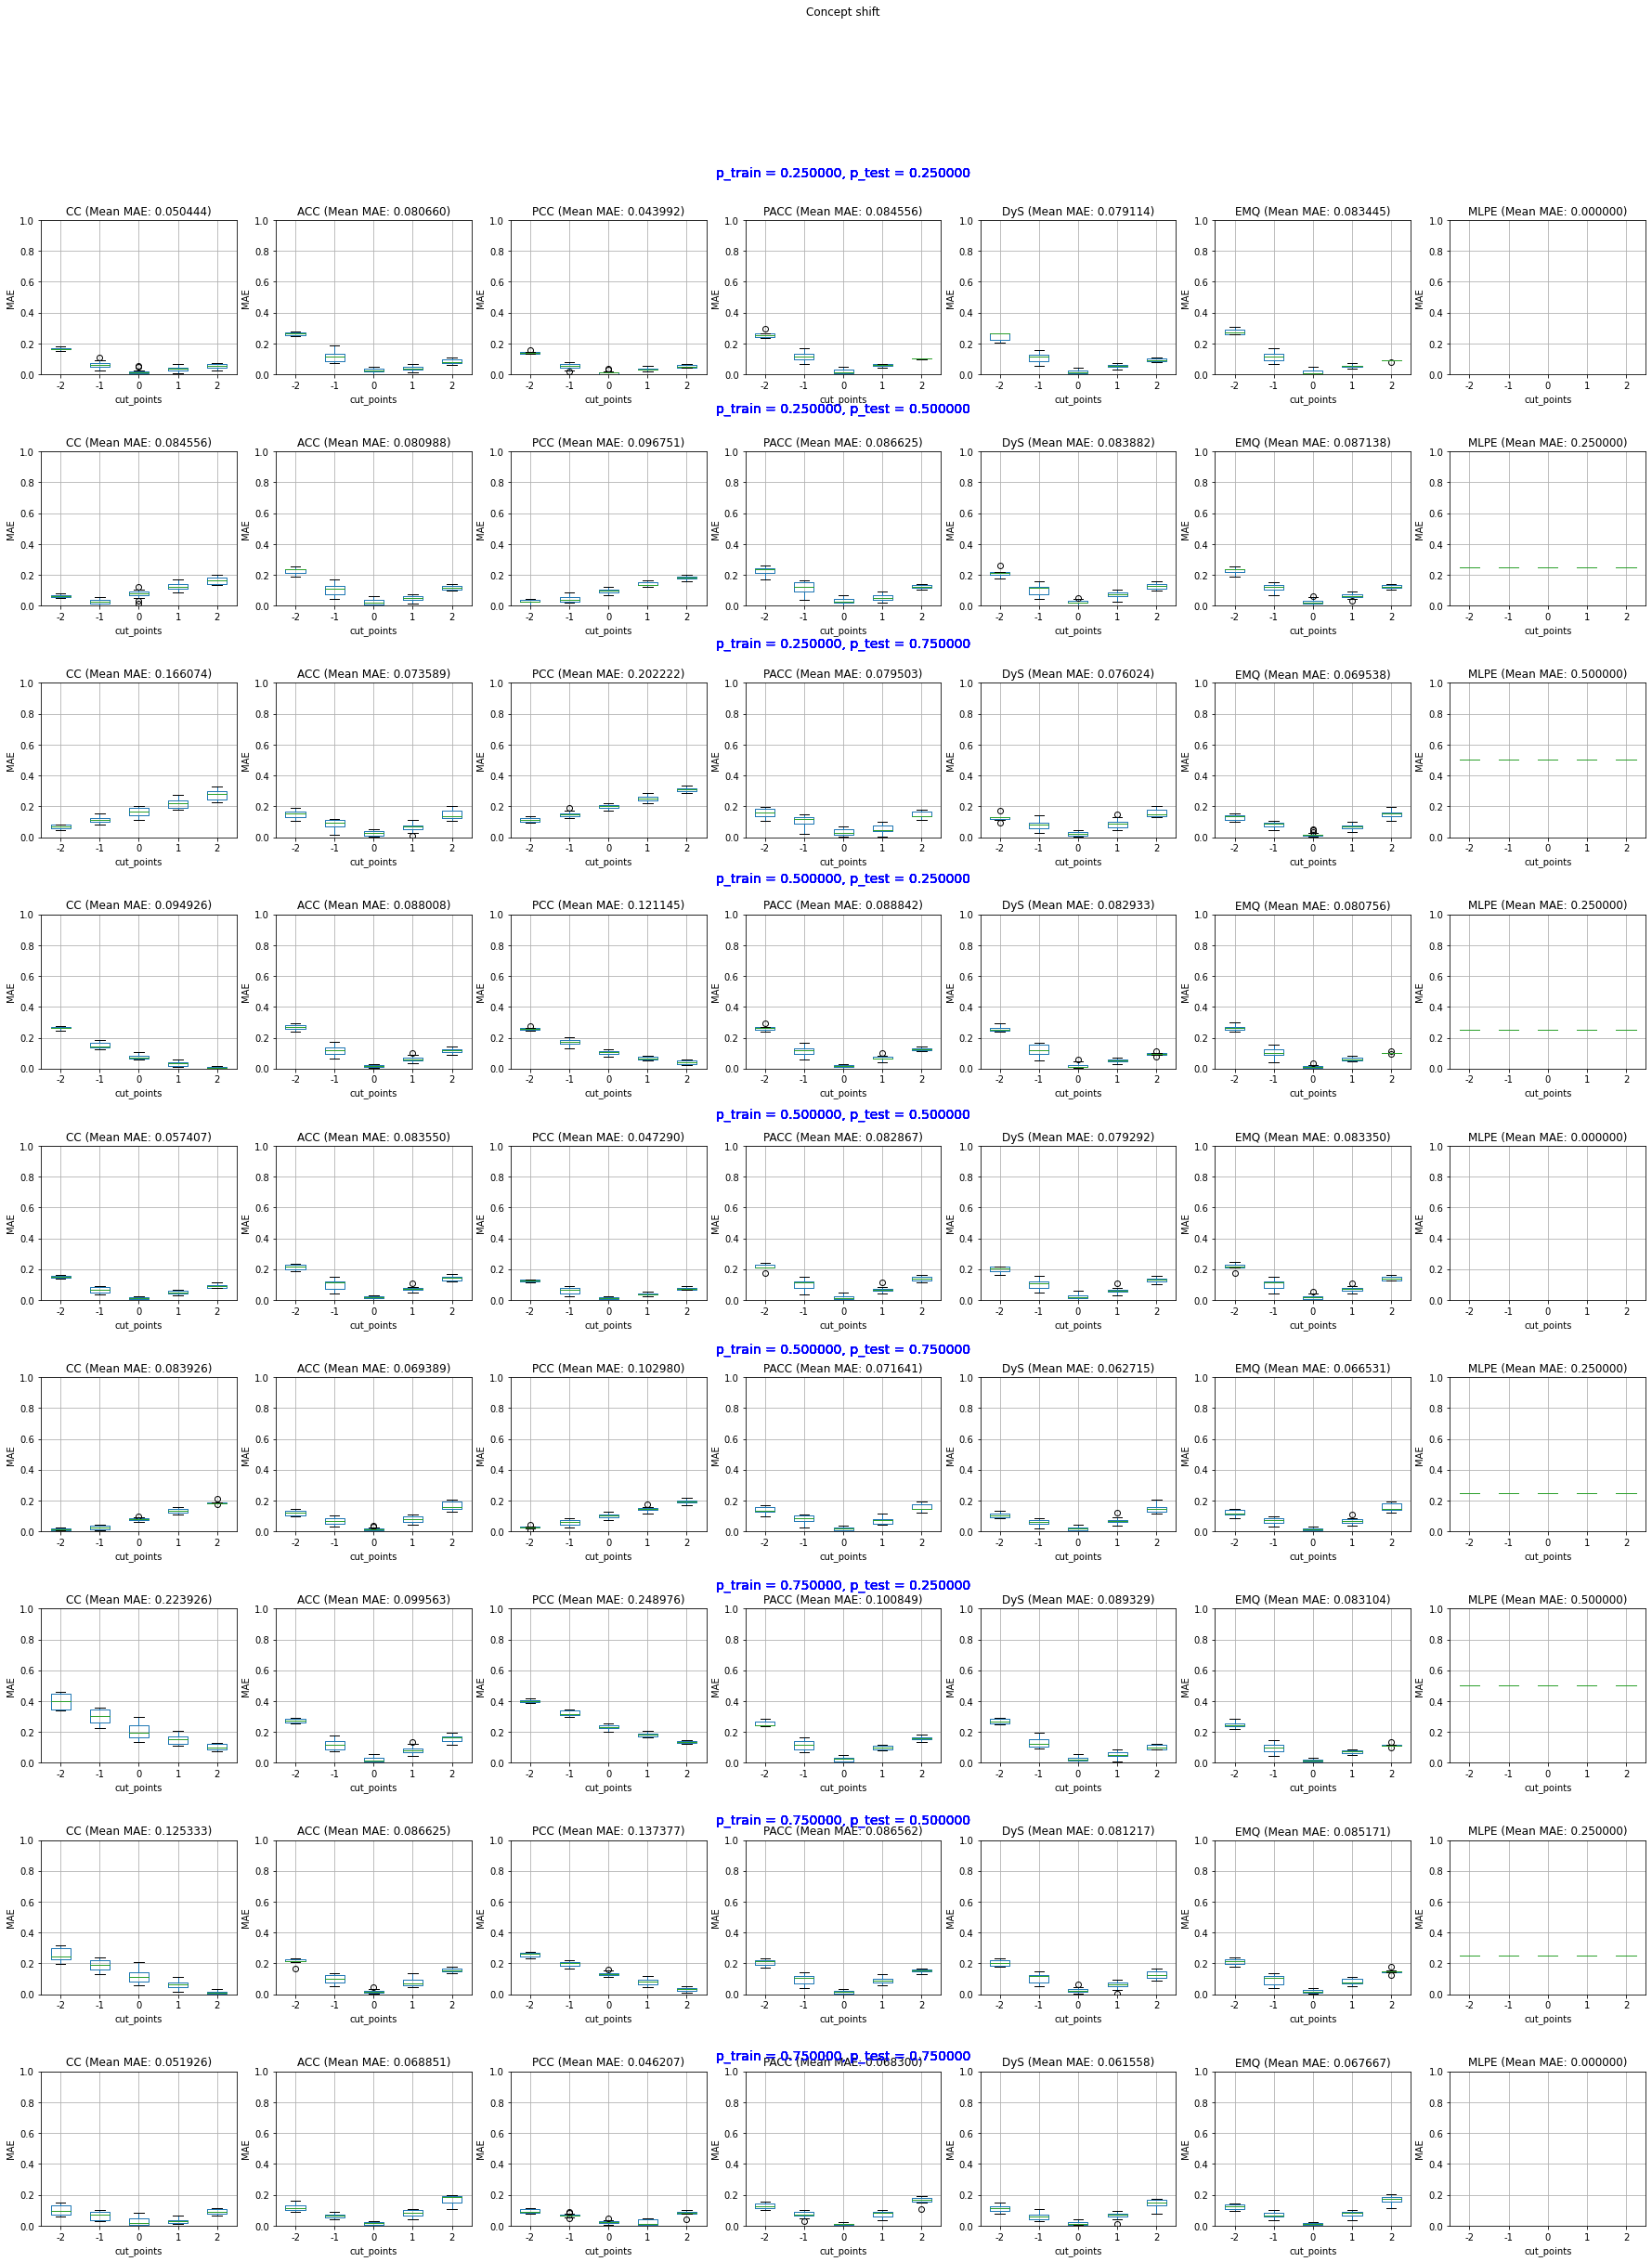

In [35]:
fig, ax = plt.subplots(len(ps_test)*len(ps_train),len(quantificators),figsize=(30,40))
plt.subplots_adjust(hspace=0.5)
for i, p_train in enumerate(ps_train):
    for j, p_test in enumerate(ps_test):
        for k,quant_name in enumerate(quantificators):
            exp_id = "%s_%f_%f" % (quant_name,p_train,p_test)
            row = i*len(ps_train)+j
            results = results_dict[quant_name]
            results = results.loc[(results['p_test'] == p_test) & (results['p_train'] == p_train)]
            ax[row][k].set_ylim(0, 1)
            ax[row][k].set_ylabel(error)
            results.boxplot(ax=ax[row][k],column='MAE',by='cut_points')
            plt.suptitle('Concept shift')
            ax[row][k].set_title("%s (Mean %s: %f)"  % (quant_name,'MAE',mean_error_methods[exp_id]))
            plt.figtext(0.5,0.92-((i*len(ps_train)+j)*0.088), "p_train = %f, p_test = %f" % (p_train,p_test), ha="center", va="top", fontsize=14, color="b")


### Tables and charts to be included in a paper

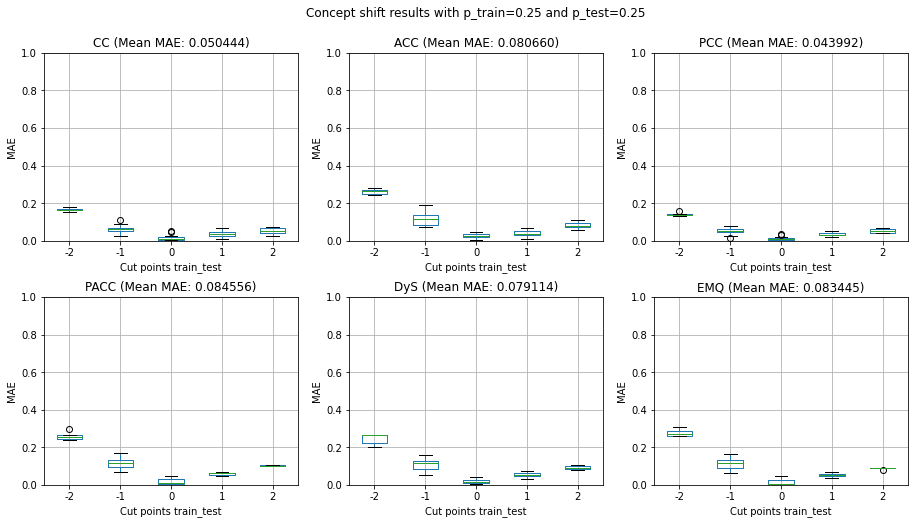

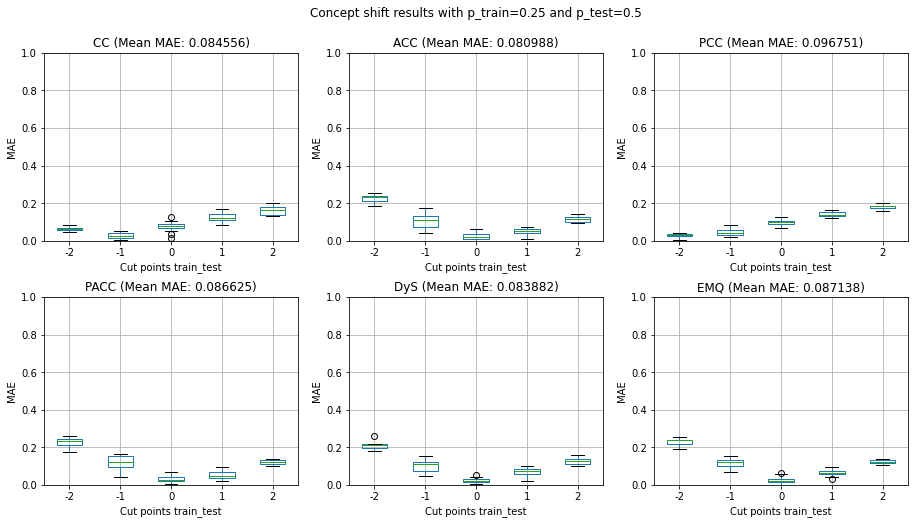

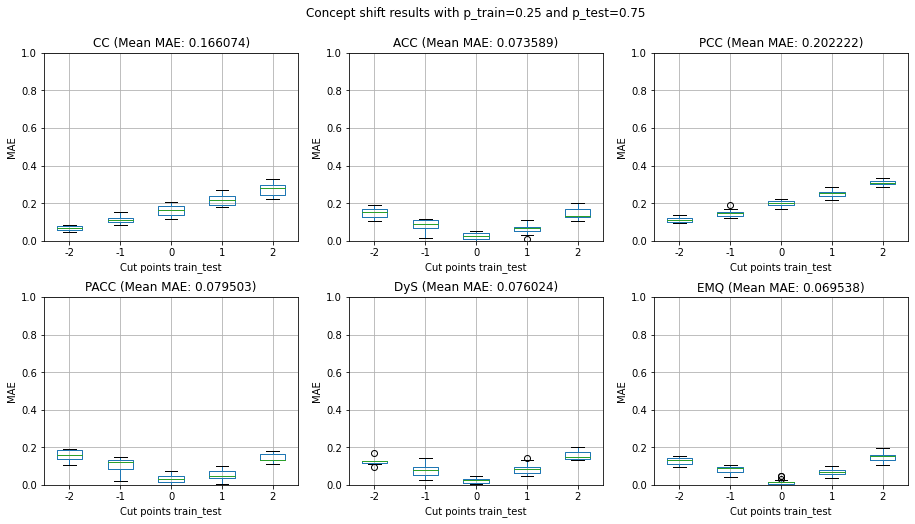

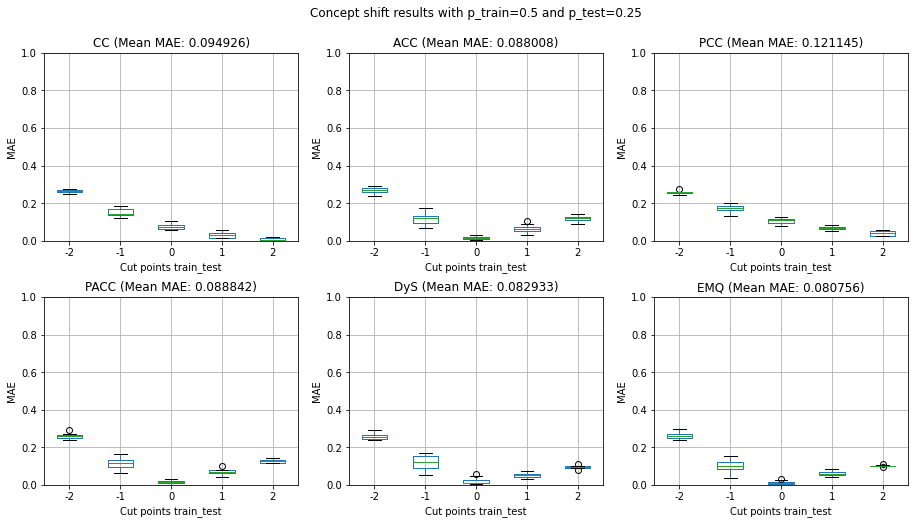

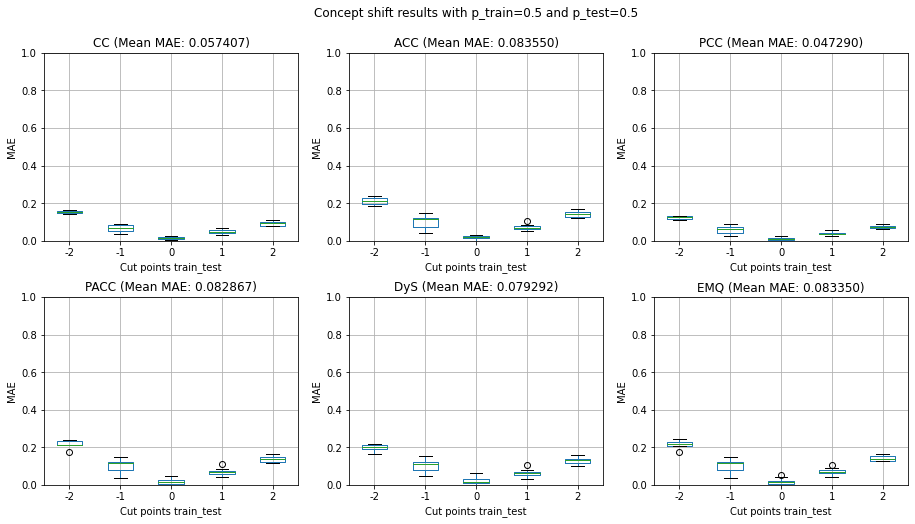

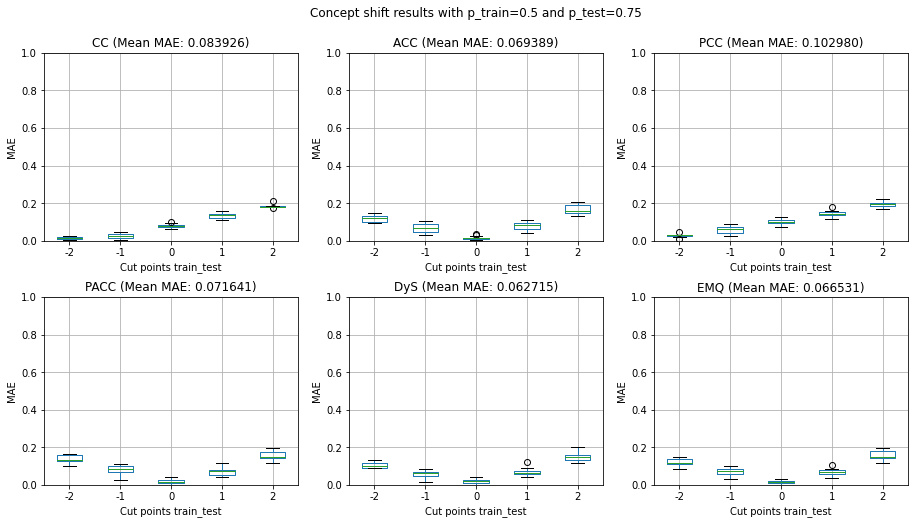

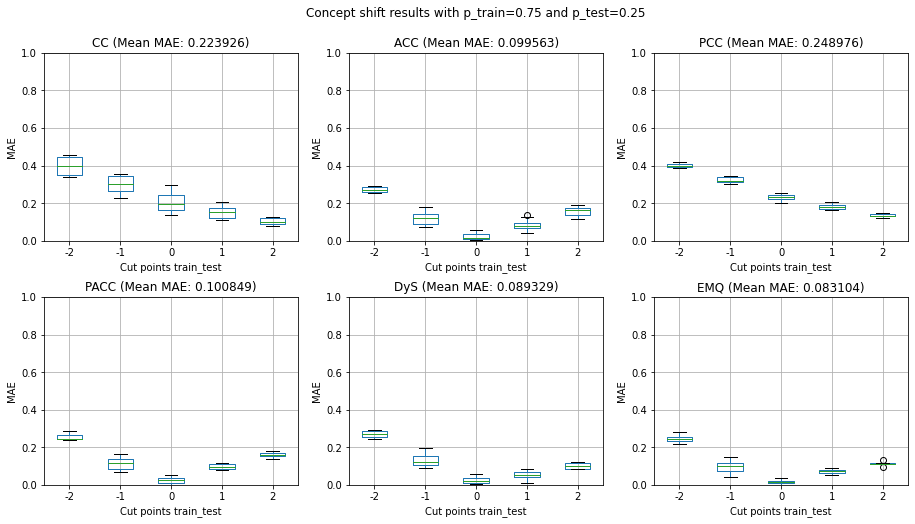

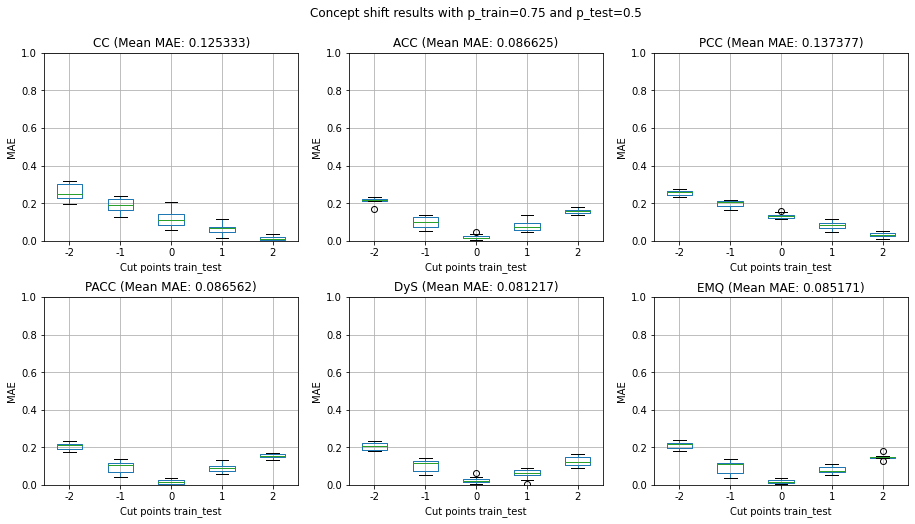

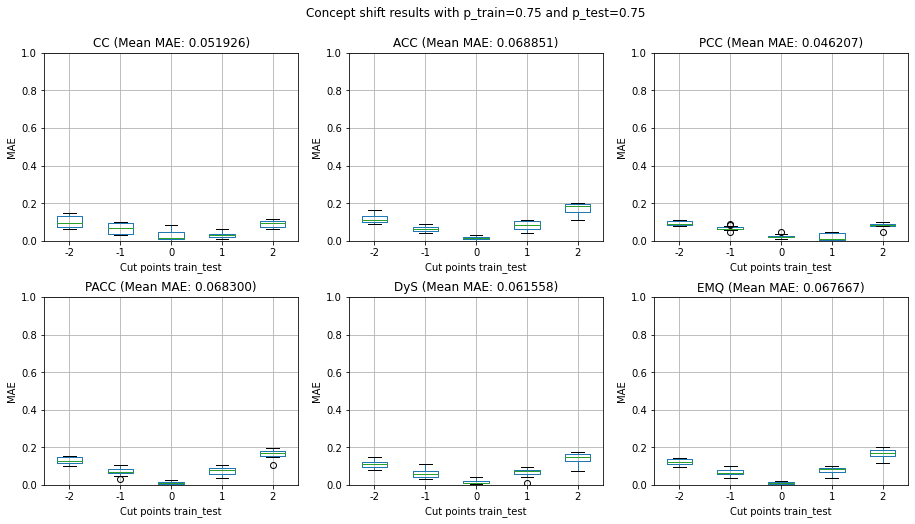

In [37]:
quantificators = ["CC", "ACC", "PCC", "PACC", "DyS", "EMQ"]
for p_train in ps_train:
    for p_test in ps_test:
        fig, ax = plt.subplots(2,3,figsize=(15,8))
        plt.subplots_adjust(hspace=0.3)
        for k,quant_name in enumerate(quantificators):
            exp_id = "%s_%f_%f" % (quant_name,p_train,p_test)
            results = results_dict[quant_name]
            results = results.loc[(results['p_test'] == p_test) & (results['p_train'] == p_train)]
            ax[k//3][k%3].set_ylim(0, 1)
            ax[k//3][k%3].set_ylabel(error)
            results.boxplot(ax=ax[k//3][k%3],column='MAE',by='cut_points')
            plt.suptitle('Concept shift results with p_train={} and p_test={}'.format(p_train, p_test))
            ax[k//3][k%3].set_xlabel("Cut points train_test")
            ax[k//3][k%3].set_title("%s (Mean %s: %f)"  % (quant_name,'MAE',mean_error_methods[exp_id]))
        plt.savefig("images/concept{}_{}.pdf".format(p_train,p_test),format='pdf')
        plt.savefig("images/concept{}_{}.png".format(p_train,p_test),format='png')


## Shorter version of charts (Bias version)

Put a chart only with PCC and EMQ which are a representation of methods for concept shift

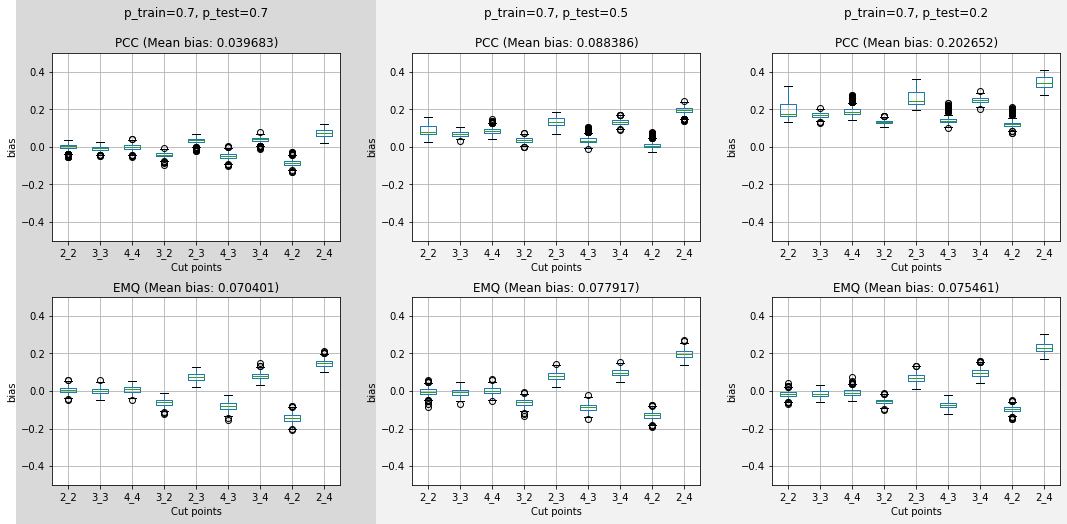

In [11]:
quantificators = ["PCC", "EMQ"]
fig = plt.figure(figsize=(15,8))
subfigs = fig.subfigures(ncols=3,wspace=2)
plt.subplots_adjust(hspace=0.3)
for j, p_test in enumerate(ps_test):
    axs = subfigs[j].subplots(nrows=2)
    for k,quant_name in enumerate(quantificators):
        exp_id = "%s_%f" % (quant_name,p_test)
        results = results_dict[quant_name]
        results = results.loc[results['p_test'] == p_test]
        axs[k].set_ylim(-0.5, 0.5)
        axs[k].set_ylabel(error)
        results.boxplot(ax=axs[k],column='error',by='cut_points')
        axs[k].set_xlabel("Cut points")
        axs[k].set_title("%s (Mean %s: %f)"  % (quant_name,error,mean_error_methods[exp_id]))
    subfigs[j].suptitle('p_train=0.7, p_test=%.1f' % p_test)

subfigs[0].set_facecolor('0.85')
subfigs[1].set_facecolor('0.95')
subfigs[2].set_facecolor('0.95')

plt.savefig("images/conceptsummary.pdf".format(p_test),format='pdf')
plt.savefig("images/conceptsummary.png".format(p_test),format='png')

## Shorter version of charts (MAE version)

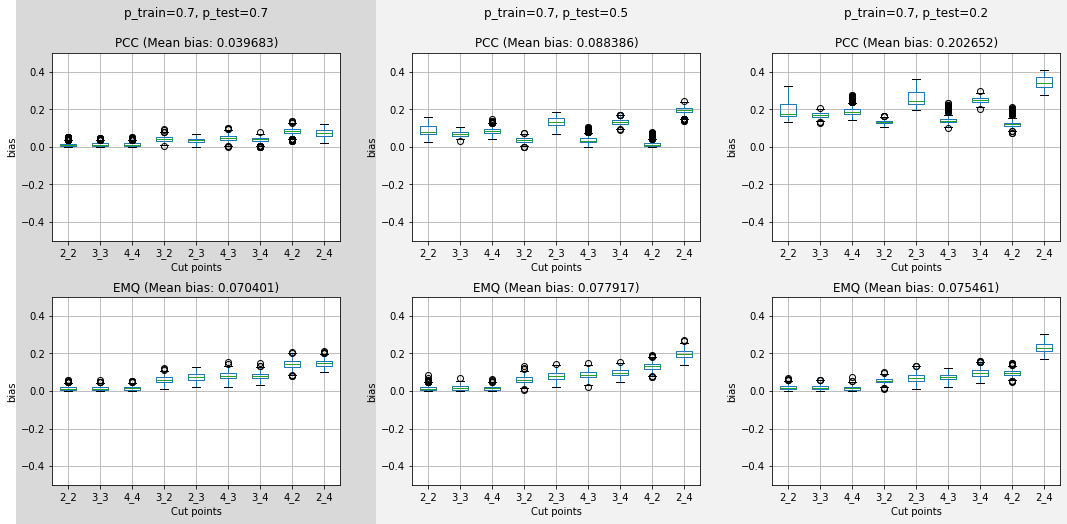

In [10]:
quantificators = ["PCC", "EMQ"]
fig = plt.figure(figsize=(15,8))
subfigs = fig.subfigures(ncols=3,wspace=2)
plt.subplots_adjust(hspace=0.3)
for j, p_test in enumerate(ps_test):
    axs = subfigs[j].subplots(nrows=2)
    for k,quant_name in enumerate(quantificators):
        exp_id = "%s_%f" % (quant_name,p_test)
        results = results_dict[quant_name]
        results = results.loc[results['p_test'] == p_test]
        axs[k].set_ylim(-0.5, 0.5)
        axs[k].set_ylabel(error)
        results.boxplot(ax=axs[k],column='MAE',by='cut_points')
        axs[k].set_xlabel("Cut points")
        axs[k].set_title("%s (Mean %s: %f)"  % (quant_name,error,mean_error_methods[exp_id]))
    subfigs[j].suptitle('p_train=0.7, p_test=%.1f' % p_test)

subfigs[0].set_facecolor('0.85')
subfigs[1].set_facecolor('0.95')
subfigs[2].set_facecolor('0.95')

plt.savefig("images/conceptsummarymae.pdf".format(p_test),format='pdf')
plt.savefig("images/conceptsummarymae.png".format(p_test),format='png')

## Main table for concept shift in the paper (version with AE)

This table has the results for concept shift. It is meant to be in the main paper.

In [5]:
from utils.wilcoxon import wilcoxon_test

quantificators = ["CC", "ACC", "PCC", "PACC", "DyS", "EMQ"]
global_results = {}
for i, p_train in enumerate(ps_train):
    columns = pd.MultiIndex.from_product([["p_test={}".format(p_test) for p_test in ps_test],quantificators])
    global_results[p_train] = pd.DataFrame(columns = columns,index=[-2,-1,0,1,2])
    for i, p_test in enumerate(ps_test):
        for k,quant_name in enumerate(quantificators):
            exp_id = "%s_%f_%f" % (quant_name,p_train,p_test)
            results = results_dict[quant_name]
            results = results.loc[(results['p_test'] == p_test) & (results['p_train'] == p_train)]
            results = results.groupby(by=['cut_points'])['MAE'].mean()
            global_results[p_train].loc[:, (["p_test={}".format(p_test)], [quant_name])] = results

global_results_style = {}
for p_train in ps_train:
    global_results_style[p_train] = global_results[p_train].style.format('{:.3f}')

for p_train in ps_train:
    for p_test in ps_test:
        #We want to make a statistical test for each row, to compare methods for the same degree of covariate shift
        for _,r in global_results[p_train].loc[:, (["p_test={}".format(p_test)])].iterrows():
            #compute the best method for this experiment
            cut_points = r.name
            best = r.index[r.argmin()]
            p_test = float(best[0][7:])
            best_method = best[1]
            #print("Computing statistical test for experiment covariate degree=%f, p_test=%s. Winner method %s" % (covariate_measure,p_test,best_method))
            #Get data for the winner method
            results_best = results_dict[best_method].loc[(results_dict[best_method]['p_test']==p_test) & (results_dict[best_method]['p_train']==p_train) & (results_dict[best_method]['cut_points']==cut_points),'error'].to_numpy()
            #We need to get all the rows in results that matches this experiment for each method
            for quant_name in quantificators:
                if quant_name!=best_method:
                    #print("Comparing %s with %s" % (best_method,quant_name))
                    results_method = results_dict[quant_name].loc[(results_dict[quant_name]['p_test']==p_test) & (results_dict[quant_name]['p_train']==p_train) & (results_dict[quant_name]['cut_points']==cut_points),'error'].to_numpy()
                    global_results_style[p_train].set_properties(subset=(cut_points, (best[0],quant_name)),**wilcoxon_test(results_best,results_method))


for p_train in ps_train:
    global_results_style[p_train] = global_results_style[p_train].highlight_min(
        axis=1,props='textbf:--rwrap;',subset=(["p_test={}".format(ps_test[0])])).highlight_min(
        axis=1,props='textbf:--rwrap;',subset=(["p_test={}".format(ps_test[1])])).highlight_min(
        axis=1,props='textbf:--rwrap;',subset=(["p_test={}".format(ps_test[2])]))
    display(global_results_style[p_train])
    columns = 'r'*len(quantificators)
    print(global_results_style[p_train].to_latex(hrules=True,multicol_align='c',column_format='l|'+columns+'|'+columns+'|'+columns).replace(' 0.',' .').replace('{0.','{.'))

\begin{tabular}{l|rrrrrr|rrrrrr|rrrrrr}
\toprule
 & \multicolumn{6}{c}{p_test=0.25} & \multicolumn{6}{c}{p_test=0.5} & \multicolumn{6}{c}{p_test=0.75} \\
 & CC & ACC & PCC & PACC & DyS & EMQ & CC & ACC & PCC & PACC & DyS & EMQ & CC & ACC & PCC & PACC & DyS & EMQ \\
\midrule
-2 & \dag{.166} & \dag{.262} & \textbf{.141} & \dag{.258} & \dag{.245} & \dag{.277} & \dag{.064} & \dag{.225} & \textbf{.028} & \dag{.226} & \dag{.213} & \dag{.227} & \textbf{.067} & \dag{.149} & \dag{.112} & \dag{.156} & \dag{.127} & \dag{.128} \\
-1 & \dag{.062} & .115 & \textbf{.052} & .115 & .109 & .115 & \textbf{.026} & .106 & .045 & .116 & .102 & .116 & .113 & \ddag{.084} & .148 & \ddag{.107} & \textbf{.079} & \ddag{.081} \\
0 & \dag{.015} & .025 & \textbf{.011} & .018 & \ddag{.016} & .016 & .077 & \dag{.025} & .097 & .031 & \textbf{.024} & \dag{.024} & .162 & \ddag{.026} & .199 & .032 & \ddag{.023} & \textbf{.016} \\
1 & \ddag{.034} & \ddag{.038} & \textbf{.034} & .059 & .054 & .054 & .125 & \textbf{.051} & .

\begin{tabular}{l|rrrrrr|rrrrrr|rrrrrr}
\toprule
 & \multicolumn{6}{c}{p_test=0.25} & \multicolumn{6}{c}{p_test=0.5} & \multicolumn{6}{c}{p_test=0.75} \\
 & CC & ACC & PCC & PACC & DyS & EMQ & CC & ACC & PCC & PACC & DyS & EMQ & CC & ACC & PCC & PACC & DyS & EMQ \\
\midrule
-2 & \ddag{.264} & \ddag{.269} & \ddag{.258} & \ddag{.262} & \textbf{.257} & \ddag{.262} & \dag{.152} & \dag{.212} & \textbf{.125} & \dag{.215} & \dag{.199} & \dag{.215} & \textbf{.015} & \dag{.120} & \dag{.027} & \dag{.137} & \dag{.105} & \dag{.119} \\
-1 & .149 & \dag{.118} & .170 & .114 & \dag{.118} & \textbf{.103} & \dag{.066} & .100 & \textbf{.059} & .102 & .099 & .102 & \textbf{.027} & .068 & .058 & .080 & .058 & .070 \\
0 & .074 & \ddag{.015} & .105 & \ddag{.015} & \dag{.019} & \textbf{.012} & \ddag{.013} & \dag{.017} & \textbf{.011} & \ddag{.017} & \ddag{.021} & \ddag{.017} & .078 & \textbf{.015} & .100 & .018 & \ddag{.018} & \dag{.015} \\
1 & \textbf{.031} & .062 & .068 & .069 & .051 & .060 & .050 & .072 & 

\begin{tabular}{l|rrrrrr|rrrrrr|rrrrrr}
\toprule
 & \multicolumn{6}{c}{p_test=0.25} & \multicolumn{6}{c}{p_test=0.5} & \multicolumn{6}{c}{p_test=0.75} \\
 & CC & ACC & PCC & PACC & DyS & EMQ & CC & ACC & PCC & PACC & DyS & EMQ & CC & ACC & PCC & PACC & DyS & EMQ \\
\midrule
-2 & \dag{.398} & \dag{.272} & \dag{.401} & \ddag{.254} & \ddag{.271} & \textbf{.247} & \dag{.258} & \ddag{.212} & \dag{.256} & \ddag{.207} & \textbf{.205} & \ddag{.212} & \ddag{.101} & \dag{.118} & \textbf{.094} & \dag{.129} & \dag{.111} & \dag{.123} \\
-1 & .299 & \dag{.119} & .323 & \dag{.113} & .132 & \textbf{.098} & .188 & \ddag{.097} & .198 & \textbf{.096} & \ddag{.104} & \ddag{.096} & \ddag{.067} & \ddag{.062} & \ddag{.067} & \ddag{.072} & \textbf{.061} & \ddag{.068} \\
0 & .205 & \ddag{.021} & .232 & \dag{.023} & .022 & \textbf{.016} & .117 & \ddag{.019} & .131 & \ddag{.017} & \dag{.024} & \textbf{.016} & \ddag{.026} & .015 & .023 & \textbf{.009} & \ddag{.016} & \ddag{.010} \\
1 & .151 & \dag{.083} & .182 & 